In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from elasticsearch_dsl import Q
import pandas as pd

client = Elasticsearch()
s = Search(using=client, index="logs_extractor") \
    .query(Q("match", log_level='WARN') | Q("match", log_level='ERROR')) \
    .source(include=["timestamp", "message", "source", "log_level"])
response = s.execute()
print(s.count())

5996


In [2]:
hits = []
for hit in s.scan():
    hits.append([hit.message, hit.source, hit.timestamp, hit.log_level])
data = pd.DataFrame(hits, columns=['message', 'source', 'timestamp', "log_level"])
data.head(5)

,message,source,timestamp,log_level
0,The saving of history tracking returned an exc...,/home/seti/Documents/ClusteringLogs/Logs/Impor...,2018-05-14 02:16:39.0966,WARN
1,Error occurred while building parsed candidate...,/home/seti/Documents/ClusteringLogs/Logs/Impor...,2018-05-12 01:04:24.8138,ERROR
2,Unhandled exception wile running process (Form...,/home/seti/Documents/ClusteringLogs/Logs/Forma...,2018-05-12 01:02:57.1995,ERROR
3,Error occurred while building parsed candidate...,/home/seti/Documents/ClusteringLogs/Logs/Impor...,2018-05-12 01:03:02.0592,ERROR
4,Error occurred while building parsed candidate...,/home/seti/Documents/ClusteringLogs/Logs/Impor...,2018-05-12 01:04:25.4232,ERROR


In [3]:
data['source'].replace(regex=True,inplace=True,to_replace=r'/home/seti/Documents/ClusteringLogs/Logs/',value=r'')
data['source'].replace(regex=True,inplace=True,to_replace=r'/.+\.log',value=r'')
data.head(5)

,message,source,timestamp,log_level
0,The saving of history tracking returned an exc...,Importing,2018-05-14 02:16:39.0966,WARN
1,Error occurred while building parsed candidate...,Importing,2018-05-12 01:04:24.8138,ERROR
2,Unhandled exception wile running process (Form...,Formatting,2018-05-12 01:02:57.1995,ERROR
3,Error occurred while building parsed candidate...,Importing,2018-05-12 01:03:02.0592,ERROR
4,Error occurred while building parsed candidate...,Importing,2018-05-12 01:04:25.4232,ERROR


In [4]:
data.groupby('source').count()['message'].plot.pie(figsize=(6, 6))

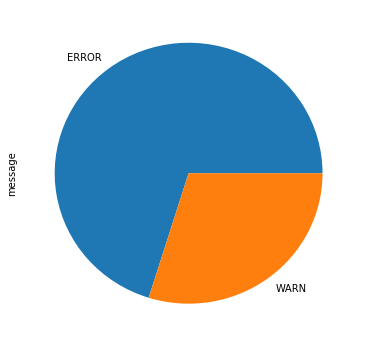

In [5]:
data.groupby('log_level').count()['message'].plot.pie(figsize=(6,6))

In [24]:
from gensim import corpora, models, similarities, matutils
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [30]:
messages = [message.split() for message in data['message']]
dictionary = corpora.Dictionary(messages)
corpus = [dictionary.doc2bow(message) for message in messages]
X = matutils.corpus2csc(corpus)

In [46]:
X = StandardScaler(with_mean=False).fit_transform(X)

<3933x5996 sparse matrix of type '<class 'numpy.float64'>'
	with 181588 stored elements in Compressed Sparse Row format>

In [57]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)

In [58]:
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)

5


In [59]:
clusters = [label for label in set(labels) if label != -1]

In [74]:
cl = [" ".join(messages[i]) for i in db.core_sample_indices_]
cl

['The saving of history tracking returned an exception System.Data.SqlClient.SqlException (0x80131904): Execution Timeout Expired. The timeout period elapsed prior to completion of the operation or the server is not responding. ---> System.ComponentModel.Win32Exception (0x80004005): The wait operation timed out',
 "Error occurred while building parsed candidate for document queue #329528 System.Data.Entity.Core.EntityException: The underlying provider failed on Open. ---> System.Data.SqlClient.SqlException: Login failed for user 'O2F-IT\\SvcToast'. Reason: Server is in single user mode. Only one administrator can connect at this time.",
 "Error occurred while matching the document #511036 System.Data.Entity.Core.EntityException: The underlying provider failed on Open. ---> System.Data.SqlClient.SqlException: Login failed for user 'O2F-IT\\SvcToast'. Reason: Server is in single user mode. Only one administrator can connect at this time.",
 "Error occurred while matching the document #51

In [63]:
cluster1 = corpus[i]

TypeError: only integer scalar arrays can be converted to a scalar index